In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project, Statistics, JLD2

[ Info: Precompiling enso_project [92f8d58f-31a9-439a-b05e-792ebdf1e7ff] (cache misses: include_dependency fsize change (2), wrong dep version loaded (2))
┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10
┌ Warning: The use of `Flux.@functor` is deprecated.
│ Most likely, you should write `Flux.@layer MyLayer`which will add various convenience methods for your type,such as pretty-printing and use with Adapt.jl.
│ However, this is not required. Flux.jl v0.15 uses Functors.jl v0.5,which makes exploration of most nested `struct`s opt-out instead of opt-in...so Flux will automatically see inside any custom struct definitions.
│ If you really want to apply the `@functor` macro to a custom struct, use `Functor

## Perform error analysis on MJO predictions

### prepare data

In [3]:
# load data
header = ["year", "month", "day", "hour", "PC1 coeff", "PC2 coeff", "PC1+PC2 amplitude"]
data = CSV.read("data/mjo_data/mjo_romi.txt", DataFrame; delim=" ", ignorerepeated=true, header=header)
pc1 = data[!,"PC1 coeff"]
pc2 = data[!,"PC2 coeff"];

# perform TDE
"D1, τ1 = enso_project.tde_with_negative_shift(pc1)
D2, τ2 = enso_project.tde_with_negative_shift(pc2)
D1, D2 = D1', D2';"

"D1, τ1 = enso_project.tde_with_negative_shift(pc1)\nD2, τ2 = enso_project.tde_with_negative_shift(pc2)\nD1, D2 = D1', D2';"

In [4]:
# train, test, val splits
train_size = 10000
val_size = 2000
#test_size = size(D1,2) - train_size - val_size
test_size = size(pc1',2) - train_size - val_size

603

In [5]:
# TDE
"train_pc1, train_pc2 = D1[:, 1:train_size],  D2[:, 1:train_size]
val_pc1, val_pc2 = D1[:, train_size+1:train_size+val_size], D2[:, train_size+1:train_size+val_size]
test_pc1, test_pc2 = D1[:, train_size+val_size+1:train_size+val_size+test_size], D2[:, train_size+val_size+1:train_size+val_size+test_size];"

# no TDE
train_pc1, train_pc2 = pc1'[:, 1:train_size],  pc2'[:, 1:train_size]
val_pc1, val_pc2 = pc1'[:, train_size+1:train_size+val_size], pc2'[:, train_size+1:train_size+val_size]
test_pc1, test_pc2 = pc1'[:, train_size+val_size+1:train_size+val_size+test_size], pc2'[:, train_size+val_size+1:train_size+val_size+test_size]

([-0.26594 -0.4044 … -0.33531 -0.37026], [0.26534 0.36134 … -0.38871 -0.34477])

### gather prediction samples

In [6]:
# sample size N
N = 200

# lead time L
L = 60

# check whether test set is large enough
test_size > N+L

true

### training

In [10]:
# for no TDE case
D1 = pc1'
D2 = pc2'

1×12603 adjoint(::Vector{Float64}) with eltype Float64:
 -0.06945  -0.04887  -0.03933  0.0199  …  -0.40887  -0.38871  -0.34477

In [7]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.14,0.1,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5, 1e-6]
reservoir_sizes = [500,700,1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [11]:
# pc1
predictions_pc1, datasets_test_pc1 = enso_project.sample_lead_times(L,N,D1, train_size, val_size,param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1641.4551650128246
enso_project.ESNHyperparams(700, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1641.1809479522246
enso_project.ESNHyperparams(1000, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1636.359037249957
enso_project.ESNHyperparams(500, 1.0, 0.1, 0.1, 0.0)
Validation loss = 1580.871869358186
Finished sample 1
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1641.5258890964246
enso_project.ESNHyperparams(700, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1641.2516720358249
enso_project.ESNHyperparams(1000, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1636.429761333557
enso_project.ESNHyperparams(500, 1.0, 0.1, 0.1, 0.0)
Validation loss = 1580.890032487252
Finished sample 2
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1641.6894284564246
enso_project.ESNHyperparams(700, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1641.4152113958248
enso_project.ESNHyperparams(1000, 0.8, 0.14, 0.1, 0.0)
Val

([-0.24348377218515438 -0.3591174578223626 … -0.07952391760526734 -0.043365019507822566; -0.4085348793966723 -0.49737057311887867 … -0.07466192338490796 -0.03900003644568972; … ; 0.5463664088260174 0.5684042904991884 … 0.03882256958081376 0.01024629601078253; 0.2883306153562586 0.13402257062944933 … -0.20343151454179154 -0.1714513647769138], [-0.26594 -0.4044 … 1.12644 0.92548; -0.4044 -0.48163 … 0.92548 0.70306; … ; 0.42023 0.3054 … -0.95618 -0.98067; 0.3054 0.19693 … -0.98067 -0.9618])

In [12]:
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L$(L)_N$(N)_predictions_pc1.csv", DataFrame(predictions_pc1, :auto))
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L$(L)_N$(N)_testsets_pc1.csv", DataFrame(datasets_test_pc1, :auto))

"C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L60_N200_testsets_pc1.csv"

In [13]:
# pc2
predictions_pc2, datasets_test_pc2 = enso_project.sample_lead_times(L,N,D2, train_size, val_size,param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1268.4801431366027
enso_project.ESNHyperparams(700, 0.8, 0.1, 0.1, 0.0)
Validation loss = 1267.6585290526114
enso_project.ESNHyperparams(1000, 0.8, 0.1, 0.1, 0.0)
Validation loss = 1242.7030851223126
enso_project.ESNHyperparams(500, 1.0, 0.5, 0.1, 1.0e-5)
Validation loss = 1227.7113264051359
Finished sample 1
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1268.5505484522027
enso_project.ESNHyperparams(700, 0.8, 0.1, 0.1, 0.0)
Validation loss = 1267.7289343682116
enso_project.ESNHyperparams(1000, 0.8, 0.1, 0.1, 0.0)
Validation loss = 1242.7735183605448
enso_project.ESNHyperparams(500, 1.0, 0.5, 0.1, 1.0e-5)
Validation loss = 1227.7833540928168
Finished sample 2
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1268.681115047803
enso_project.ESNHyperparams(700, 0.8, 0.1, 0.1, 0.0)
Validation loss = 1267.8595009638116
enso_project.ESNHyperparams(1000, 0.8, 0.1, 0.1, 0.0)


([0.23747089073630567 0.301634560168063 … 0.20330091496658875 0.21028087538797768; 0.3634315326468158 0.47523300412878555 … 0.26140467635509834 0.2637568604971383; … ; 0.7930114451984203 0.5872141532752586 … -0.18030019535938502 -0.20074320586354966; 0.6649381498694993 0.49525926134002773 … -0.13484809587494784 -0.16191614004371058], [0.26534 0.36134 … 1.24953 1.41313; 0.36134 0.49521 … 1.41313 1.52727; … ; 0.82764 0.68098 … -0.22188 -0.41102; 0.68098 0.62987 … -0.41102 -0.56708])

In [14]:
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L$(L)_N$(N)_predictions_pc2.csv", DataFrame(predictions_pc2, :auto))
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L$(L)_N$(N)_testsets_pc2.csv", DataFrame(datasets_test_pc2, :auto))

"C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L60_N200_testsets_pc2.csv"

### error analysis with TDE

In [42]:
predictions_pc1 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_tde_L$(L)_N$(N)_predictions_pc1.csv", DataFrame))
datasets_test_pc1 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_tde_L$(L)_N$(N)_testsets_pc1.csv", DataFrame));

predictions_pc2 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_tde_L$(L)_N$(N)_predictions_pc2.csv", DataFrame))
datasets_test_pc2 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_tde_L$(L)_N$(N)_testsets_pc2.csv", DataFrame));

In [43]:
rmse_vals = enso_project.rmse(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
corr_vals = enso_project.bivariate_corr(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
error_tde = plot(rmse_vals, label="RMSE", xlabel="Lead Times (days)", ylabel="Error Index", ylim=(-0.1,2.3), title="MJO Prediction TDE, N=$N", color=:blue)
plot!(corr_vals,label="CORR",color=:orange)
hline!([1.4], color=:blue, linestyle=:dash, label="")
hline!([0.5], color=:orange, linestyle=:dash, label="");
#savefig("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/fig_saves/mjo_error.png")

In [44]:
phase_error = enso_project.phase_error(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
phase_error_tde = plot(phase_error, ylim=(-0.3,0.3), label="phase error", xlabel="Lead Time (days)", ylabel="", title="MJO Prediction TDE, N=$N", color=:blue);

In [45]:
hss_vals = enso_project.hss(predictions_pc1,predictions_pc2,datasets_test_pc1, datasets_test_pc2)

hss_tde = heatmap(hss_vals,
    #color=:viridis,   # choose your colormap
    title="MJO HSS Heatmap TDE, N=$N",
    xlabel="Lead time",
    ylabel="Phase",
    na_color=:white,   # color for NaN values
    yticks=(1:9, ["inaktive","1","2","3","4","5","6","7","8"])
);

#savefig("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/fig_saves/mjo_error_hss.png")

### error analysis without TDE

In [35]:
predictions_pc1 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L$(L)_N$(N)_predictions_pc1.csv", DataFrame))
datasets_test_pc1 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L$(L)_N$(N)_testsets_pc1.csv", DataFrame));

predictions_pc2 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L$(L)_N$(N)_predictions_pc2.csv", DataFrame))
datasets_test_pc2 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_no_tde_L$(L)_N$(N)_testsets_pc2.csv", DataFrame));

In [36]:
rmse_vals = enso_project.rmse(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
corr_vals = enso_project.bivariate_corr(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
error_no_tde = plot(rmse_vals, label="RMSE", xlabel="Lead Times (days)", ylabel="Error Index", ylim=(-0.1,2.3), title="MJO Prediction no TDE, N=$N", color=:blue)
plot!(corr_vals,label="CORR", color=:orange)
hline!([1.4], color=:blue, linestyle=:dash, label="")
hline!([0.5], color=:orange, linestyle=:dash, label="");

In [41]:
phase_error = enso_project.phase_error(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
phase_error_no_tde = plot(phase_error, ylim=(-0.3,0.3),label="phase error", xlabel="Lead Time (days)", ylabel="", title="MJO Prediction no TDE, N=$N", color=:blue);

In [38]:
hss_vals = enso_project.hss(predictions_pc1,predictions_pc2,datasets_test_pc1, datasets_test_pc2)

hss_no_tde = heatmap(hss_vals,
    #color=:viridis,   # choose your colormap
    title="MJO HSS Heatmap no TDE, N=$N",
    xlabel="Lead time",
    ylabel="Phase",
    na_color=:white,   # color for NaN values
    yticks=(1:9, ["inaktive","1","2","3","4","5","6","7","8"])
);

### Compare both

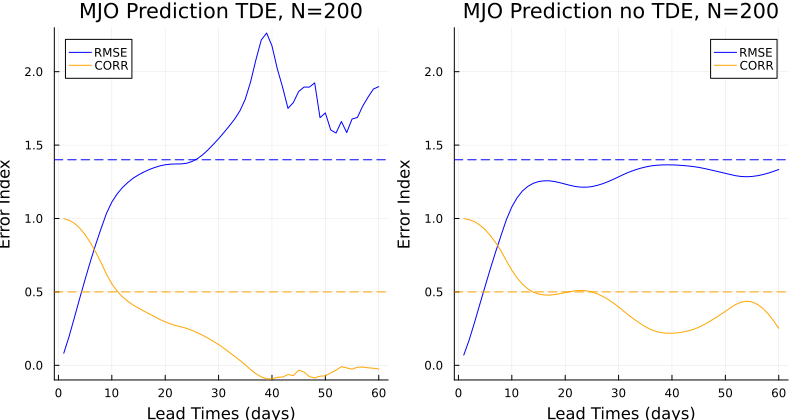

In [39]:
# compare error curves
plot(error_tde, error_no_tde, layout=(1,2), size=(800,420))

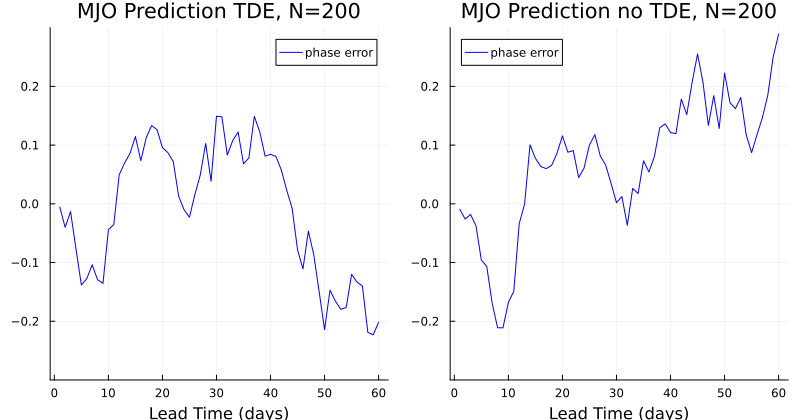

In [46]:
plot(phase_error_tde,phase_error_no_tde,layout=(1,2), size=(800,420))

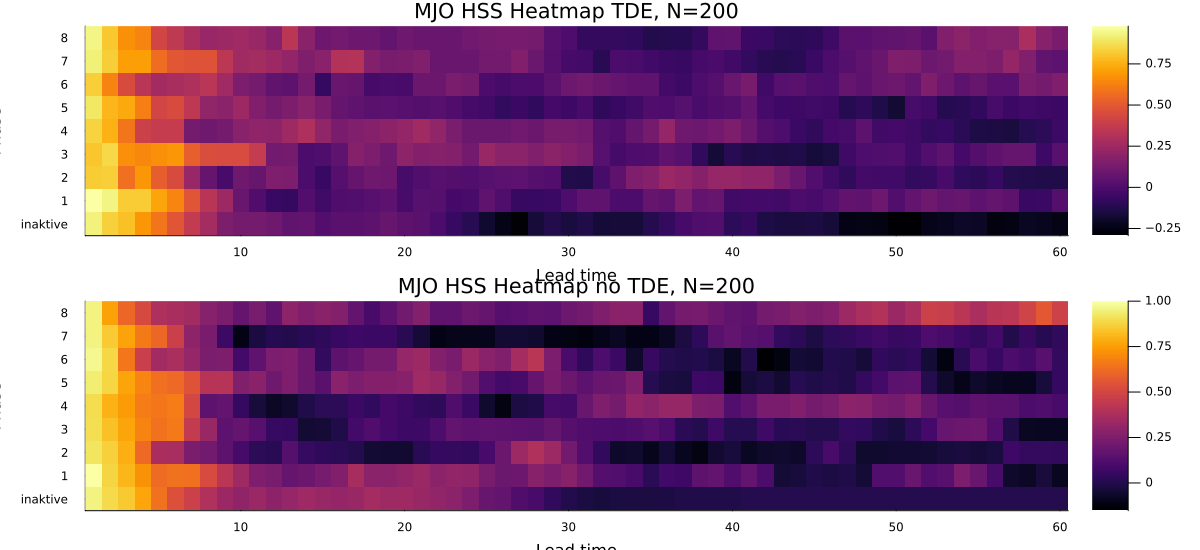

In [37]:
# compare hss heatmaps
plot(hss_tde, hss_no_tde, layout=(2,1), size=(1200,550))